In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc 
from scipy.cluster.hierarchy import fcluster

In [114]:
os.getcwd()
os.listdir('/home/user/work/DABI/Task2')
df = pd.read_csv('/home/user/work/DABI/Task2/plr_smpl_attempts.csv',sep=";")

In [115]:
df['event_time'] = df['event_time'].str.replace(',', '.').astype(float)
df['event_time'] = pd.to_datetime(df['event_time'], unit='ms')

In [116]:
duplicated_rows = df.duplicated().sum()
df_unique = df.drop_duplicates(keep = 'first')
df_unique.head()

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 01:00:00
5,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 14:53:20
12,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 17:40:00
15,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,114,2017-12-01 20:26:40
18,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,114,2017-12-01 17:40:00


hour
1      685
3      879
6      936
9      918
12     988
14    1063
17    1014
20     870
23     643
dtype: int64


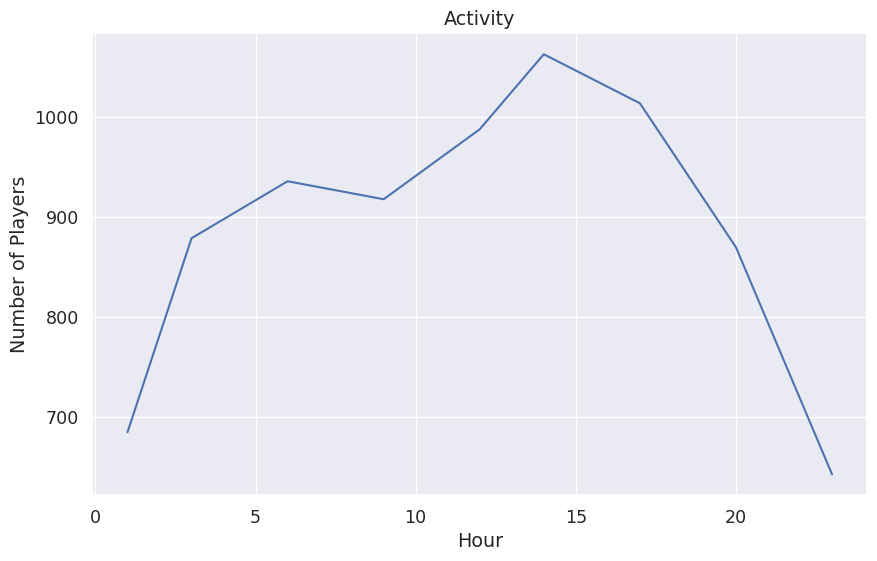

In [118]:
# determining the location of users

df_unique.loc[:, 'hour'] = df_unique['event_time'].dt.hour
df_unique.head()

hourly_distribution = df_unique.groupby('hour').size()
print(hourly_distribution)
plt.figure(figsize = (10, 6))
sns.lineplot(x = hourly_distribution.index, y = hourly_distribution.values)
plt.xlabel('Hour')
plt.ylabel('Number of Players')
plt.title('Activity')
plt.show()

Use the following approach to determine the localisation of users:

Determine the number of users active in each hour of the day.
Construct a graph of user activity based on this data.
Identify the time zone:

Assume that activity peaks in the graph may occur during commuting times.
It is necessary to correlate the time peaks with possible time zones to identify the potential geographic location of users.
Based on the assumption that users are most active during commuting and after work, we can conclude that this dataset is likely to belong to Central Asian regions such as Kazakhstan, Tajikistan, Uzbekistan and Turkmenistan, as well as parts of Russia at similar longitudes.

In [119]:
grouped_df = df_unique.groupby(['uid', 'level'])
df_user_level = grouped_df.agg(
                               attempts = ('level', 'count'),  
                               completed = ('action', 'min')
                               ).reset_index() 
df_user_level.head()

,uid,level,attempts,completed
0,M0duNVNHSlMxMjA0MzI3MTAyMDE0MA,164,2,completed
1,M0duNVNHSlMxMjA0MzI3MTAyMDE0MA,165,1,failed
2,M0pvNU42VmoxMjYyNDE3MTAyOTA2Mg,126,2,completed
3,M0pvNU42VmoxMjYyNDE3MTAyOTA2Mg,127,3,completed
4,M0pvNU42VmoxMjYyNDE3MTAyOTA2Mg,128,2,completed


Creating a new detaset containing user id, level number passed, level completion status.

In [120]:
df_user_level = df_user_level.sort_values(by = ['uid', 'level'])  
df_user_level['level_diff'] = df_user_level.groupby('uid')['level'].diff()
missed_levels = df_user_level[df_user_level['level_diff'] > 1]

#deleting players with missing levels (cheaters)
valid_user_level = df_user_level[~df_user_level['uid'].isin(missed_levels['uid'])]

Detect and remove cheaters - users who are suspected of skipping game levels. The result will be a new dataframe with only those users remaining who have completed all levels of the game in the correct sequence, without suspected skips.

In [121]:
attempts_count = valid_user_level.groupby('level')['attempts'].sum() #total number of attempts to pass a level
user_count = valid_user_level.groupby('level')['uid'].count() #Number of users that have been to the level
pass_level = valid_user_level.groupby('level')['completed'].apply(lambda x: (x == 'completed').sum())  #Passed the level
rem_level = valid_user_level.groupby('level')['completed'].apply(lambda x: (x == 'failed').sum())  #Remaining on the level 

#level of complexity = number of successful attempts to pass levels/total number of attempts
complex_level = (valid_user_level.groupby('level')['completed'].apply(lambda x: (x == 'completed').sum())/valid_user_level.groupby('level')['attempts'].sum()).round(2)

metrics = pd.DataFrame({
                        'level': valid_user_level['level'].unique(),   
                        'user_count': user_count.reindex(valid_user_level['level'].unique(), fill_value = 0).values,     
                        'pass_level': pass_level.reindex(valid_user_level['level'].unique(), fill_value = 0).values,  
                        'rem_level': rem_level.reindex(valid_user_level['level'].unique(), fill_value = 0).values,   
                        'attempts_count': attempts_count.reindex(valid_user_level['level'].unique(), fill_value = 0).values,
                        'complex_level': complex_level.reindex(valid_user_level['level'].unique(), fill_value = 0).values})

metrics['percent_pass'] = (metrics['pass_level'] / metrics['user_count'] * 100).round(2) #% of passing users 
metrics.head()

,level,user_count,pass_level,rem_level,attempts_count,complex_level,percent_pass
0,164,15,8,7,29,0.28,53.33
1,165,12,7,5,22,0.32,58.33
2,126,14,13,1,27,0.48,92.86
3,127,18,15,3,45,0.33,83.33
4,128,25,16,9,51,0.31,64.00


Creating a dataframe of metrics for each level includes the following steps:

Metrics are calculated for each level of the game:

    Total number of attempts to complete the level.
    Number of users who have been to the level at least once.
    Number of users who successfully completed the level.
    Number of users who failed to complete the level.
    Percentage of users who completed the level.
    The difficulty of the level, defined as the ratio of the number of successful attempts to the total number of attempts.

In [122]:
metrics[['attempts_count', 'pass_level', 'rem_level', 'complex_level', 'percent_pass'] ].describe().round(2)

,attempts_count,pass_level,rem_level,complex_level,percent_pass
count,396.00,396.00,396.00,396.00,396.00
mean,19.95,7.56,3.18,0.42,75.65
std,19.73,7.24,4.58,0.21,26.61
min,1.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,0.00,0.29,57.14
50%,12.50,4.00,1.00,0.40,82.22
75%,32.25,13.00,4.00,0.50,100.00
max,84.00,27.00,29.00,1.00,100.00


Calculation of descriptive statistics for each metric. The statistics allow you to characterise the distribution of values, identify average trends, measure dispersion and detect possible anomalies for each metric in the dataframe.

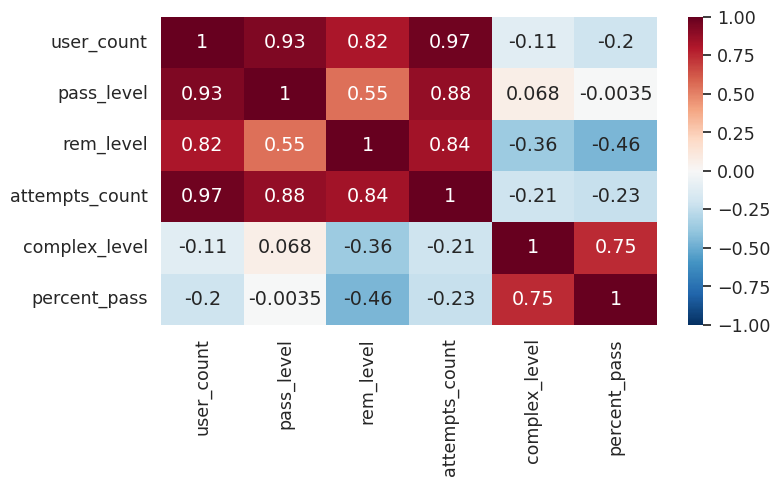

In [109]:
sns.set(font_scale = 1.15)
plt.figure(figsize = (8, 4))
sns.heatmap(
            metrics[['user_count', 'pass_level', 'rem_level', 'attempts_count', 'complex_level', 'percent_pass']].corr(),
            cmap = 'RdBu_r', annot = True, 
            vmin = -1, vmax = 1); 

In [123]:
numeric_columns = ['user_count', 'pass_level', 'rem_level', 'attempts_count', 'complex_level', 'percent_pass']
scaler = StandardScaler()
metrics_scaled = pd.DataFrame(scaler.fit_transform(metrics[numeric_columns]), columns = numeric_columns)
metrics_scaled = pd.concat([metrics[['level']], metrics_scaled], axis = 1)

Standlartisation of data for subsequent cluster analysis.

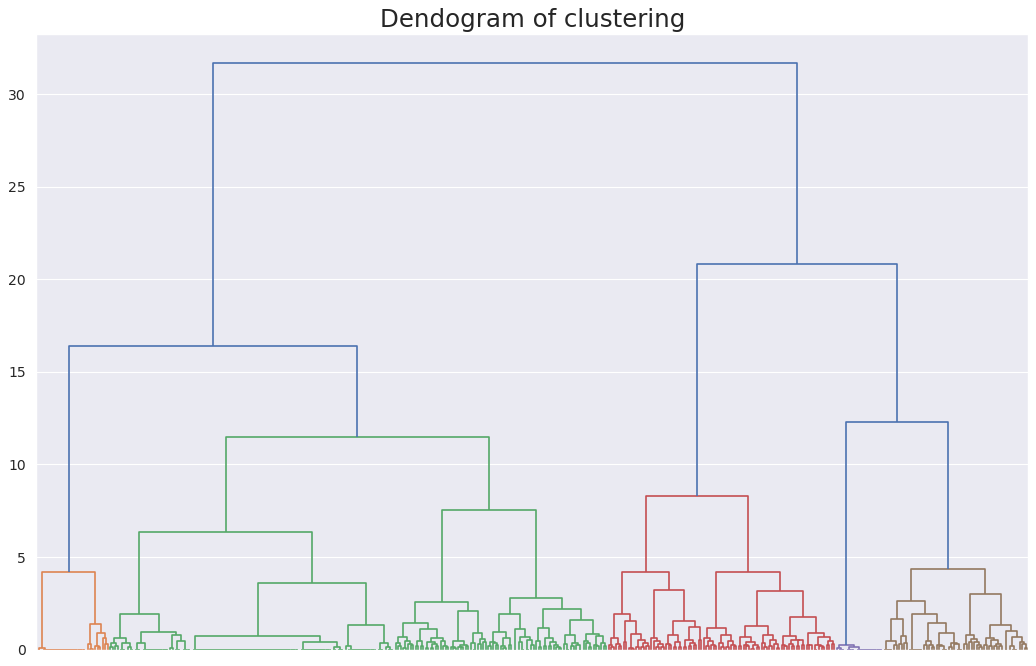

     level  cluster
0      164        4
1      165        4
2      126        2
3      127        3
4      128        3
..     ...      ...
391    452        2
392    453        1
393    454        2
394    225        2
395    229        1

[396 rows x 2 columns]


In [124]:
# Classification of complexity levels based on cluster analysis
# Calculating the relationship matrix

D = shc.linkage(metrics_scaled[['complex_level', 'percent_pass', 'attempts_count']], method = 'ward')

plt.figure(figsize = (16, 10), dpi = 80)  
plt.title("Dendogram of clustering", fontsize = 22)  
dend = shc.dendrogram(D, color_threshold = 12)  
plt.xticks([])
plt.show()

# Dendrogram partitioning into clusters based on distance
threshold = 14 
clusters = fcluster(D, threshold, criterion = 'distance')

metrics1 = metrics
metrics1['cluster'] = clusters

print(metrics1[['level', 'cluster']])



Classification of game levels into complexity categories was done using cluster analysis. Based on four metrics: `complex_level`, `percent_pass`, `attempts_count` the game levels were distributed into four clusters. The classification results were stored in a dataframe in which the difficulty category information for each level was added.
Cluster analysis allows the game levels to be efficiently defined and classification by difficulty, providing a structured and intuitive way to manage game levels.

(array([ 24., 133.,  92., 104.,  18.,  25.]),
 array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        ]),
 <BarContainer object of 6 artists>)

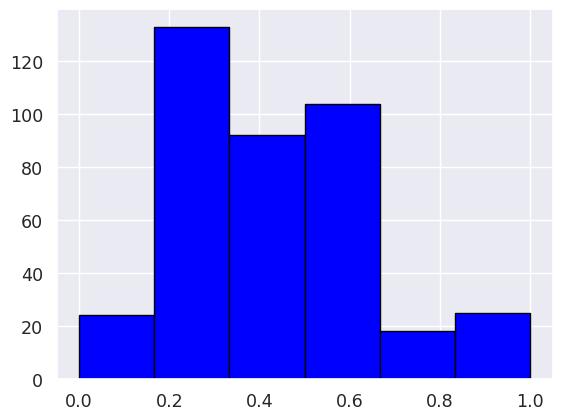

In [125]:
plt.hist(metrics['complex_level'], 
         color = 'blue', edgecolor = 'black',
         bins = 6)

The distribution histogram of the Level Complexity metric suggests visually that the data has a normal distribution. However, to confirm this assumption it is necessary to conduct a normality test. The test results can be the basis for choosing appropriate statistical methods for further analysis of this metric.

In [126]:
# Classification of complexity levels based on quantile distributions 

qmin = metrics['complex_level'].min()
q25 = metrics['complex_level'].quantile(0.25)
q50 = metrics['complex_level'].quantile(0.50)
q75 = metrics['complex_level'].quantile(0.75)
xmax = q75 + 1.5 * (q75 - q25)
qmax = metrics['complex_level'].max()

bins = [qmin, q25, q50, q75, xmax, qmax]
labels = ['Master', 'Expert', 'Hard', 'Medium', 'Easy']

metrics['complex_cat'] = pd.cut(metrics['complex_level'], bins = bins, labels = labels, include_lowest = True)
print(metrics.groupby('complex_cat', observed = True)['complex_cat'].count())

complex_cat
Master    104
Expert     98
Hard      116
Medium     52
Easy       26
Name: complex_cat, dtype: int64


In [126]:
# Classification of complexity levels based on quantile distributions 

qmin = metrics['complex_level'].min()
q25 = metrics['complex_level'].quantile(0.25)
q50 = metrics['complex_level'].quantile(0.50)
q75 = metrics['complex_level'].quantile(0.75)
xmax = q75 + 1.5 * (q75 - q25)
qmax = metrics['complex_level'].max()

bins = [qmin, q25, q50, q75, xmax, qmax]
labels = ['Master', 'Expert', 'Hard', 'Medium', 'Easy']

metrics['complex_cat'] = pd.cut(metrics['complex_level'], bins = bins, labels = labels, include_lowest = True)
print(metrics.groupby('complex_cat', observed = True)['complex_cat'].count())

complex_cat
Master    104
Expert     98
Hard      116
Medium     52
Easy       26
Name: complex_cat, dtype: int64


Classification of game levels into complexity categories was performed based on quantiles of the `level_complexity` metric. The choice of this metric as a classification criterion is based on the following:
    the metric has no dimensionality and represents a relative characteristic
    similar relative metric `level completion rate` has a strong positive correlation with the metric `level complexity`.
Each level of the game was assigned one of five difficulty categories depending on which quantile interval its difficulty value falls into.

In [111]:
# visual analysis of the game levels for the Master complexity category
print(metrics[metrics['complex_cat'] == 'Master'].sort_values(by = 'level', ascending = False).tail(50))
print(metrics[metrics['complex_cat'] == 'Master'].sort_values(by = 'level', ascending = False).head(50))

     level  user_count  pass_level  rem_level  attempts_count  complex_level  \
46     189           9           5          4              17           0.29   
43     186          12           8          4              29           0.28   
219    183           5           3          2              12           0.25   
290    181           2           1          1               4           0.25   
289    180           3           2          1               8           0.25   
71     178           7           3          4              17           0.18   
218    176          10           7          3              26           0.27   
178    173           9           4          5              20           0.20   
111    169          11           7          4              27           0.26   
133    167          10           3          7              21           0.14   
155    166          12           6          6              28           0.21   
0      164          15           8      

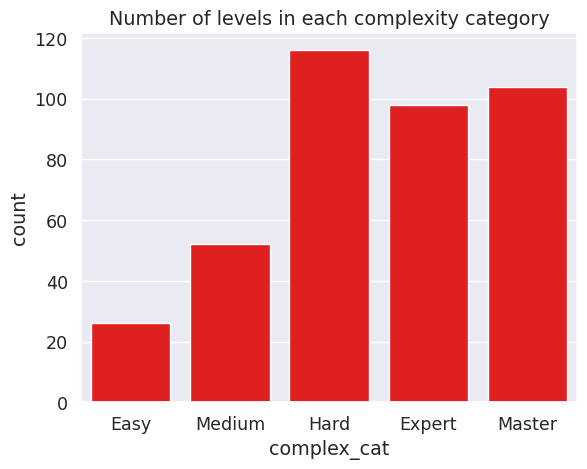

In [112]:
sns.countplot(x ='complex_cat', data = metrics,color ='red')
plt.gca().invert_xaxis()  
plt.title('Number of levels in each complexity category')
plt.show()

Visualisation of the number of levels of the game by complexity category.

In [105]:
print(metrics.groupby('complex_cat', observed = True)['complex_level'].describe())

             count      mean       std   min     25%   50%     75%   max
complex_cat                                                             
Master       104.0  0.195577  0.100993  0.00  0.1700  0.24  0.2700  0.29
Expert        98.0  0.347347  0.029482  0.30  0.3300  0.33  0.3775  0.40
Hard         116.0  0.476810  0.032480  0.41  0.4500  0.50  0.5000  0.50
Medium        52.0  0.617115  0.066667  0.51  0.5675  0.61  0.6700  0.80
Easy          26.0  0.980385  0.046258  0.83  1.0000  1.00  1.0000  1.00


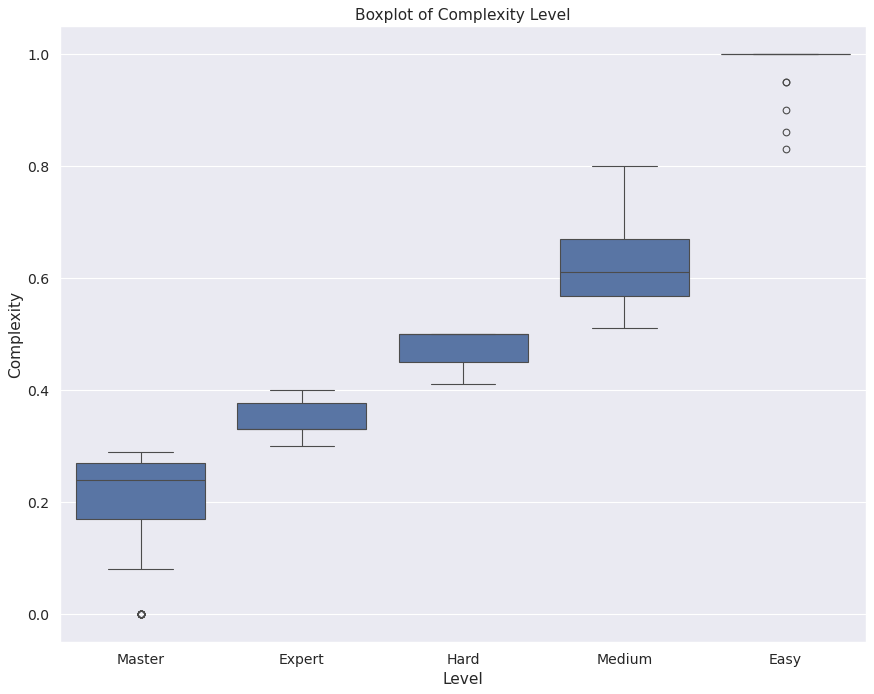

In [106]:
plt.figure(figsize = (13, 10), dpi = 80)
sns.boxplot(x ='complex_cat', y = 'complex_level', data = metrics)
plt.xlabel('Level')
plt.ylabel('Complexity')
plt.title('Boxplot of Complexity Level')
plt.show()

For each complexity category, a box plot was constructed. The box plot shows the median, quartile ranges, and outliers for the level difficulty metric. And illustrates the variability of the metric depending on the difficulty category.

In [107]:
category = metrics.groupby ('complex_cat',observed = False).agg(
                            user_count = ('user_count', 'sum'),  
                            pass_level = ('pass_level', 'sum'),     
                            rem_level = ('rem_level', 'sum'),
                            complex_level = ('complex_level', 'mean')
                            ).reset_index()

Created a new dataframe with aggregated metrics for each complexity category

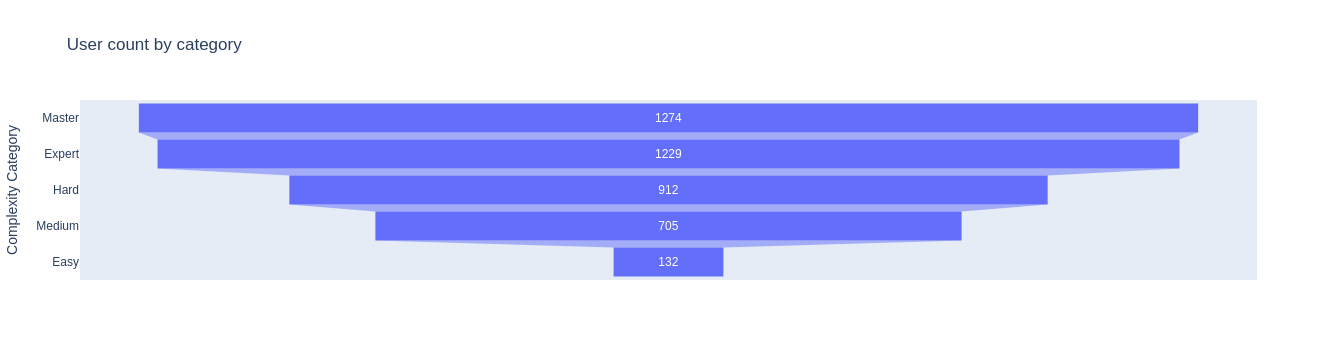

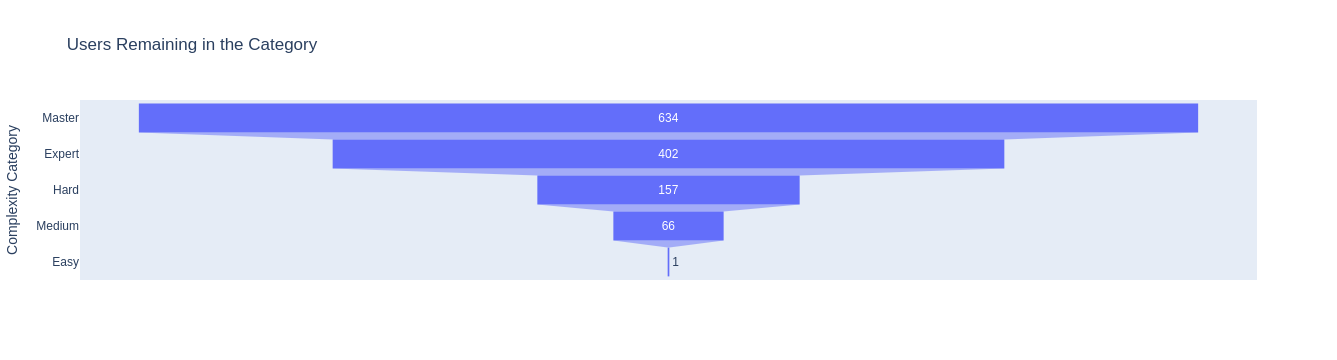

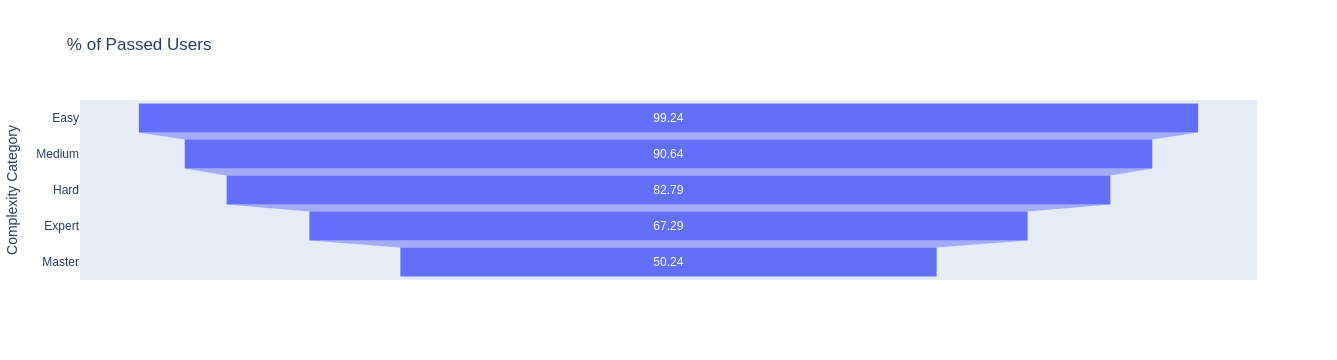

In [113]:
df_count = category[['complex_cat', 'user_count']].sort_values(by = "user_count", ascending = False)
df_count['stage'] = "User count by category"

rem = category[['complex_cat','rem_level']].sort_values(by = "rem_level", ascending = False)
rem['stage'] = "Remaining on the category"

per = category.copy()
per['percentage'] = (per['pass_level'] / per['user_count'] * 100).round(2)
per = per[['complex_cat', 'percentage']]
per = per.sort_values(by = 'percentage', ascending = False)
per['stage'] = '% of passed users'

all_data = pd.concat([df_count, rem, per])

gr1 = px.funnel(df_count, x = "user_count", y = "complex_cat", title = "User count by category")
gr2 = px.funnel(rem, x = 'rem_level', y = 'complex_cat', title = 'Users Remaining in the Category')
gr3 = px.funnel(per, x = 'percentage', y = 'complex_cat', title = '% of Passed Users')

gr1.update_layout(yaxis_title = 'Complexity Category', xaxis_title = 'Passed Level')
gr2.update_layout(yaxis_title = 'Complexity Category', xaxis_title = 'Remaining Level')
gr3.update_layout(yaxis_title = 'Complexity Category', xaxis_title = '% of Passed Users')

gr1.show()
gr2.show()
gr3.show()

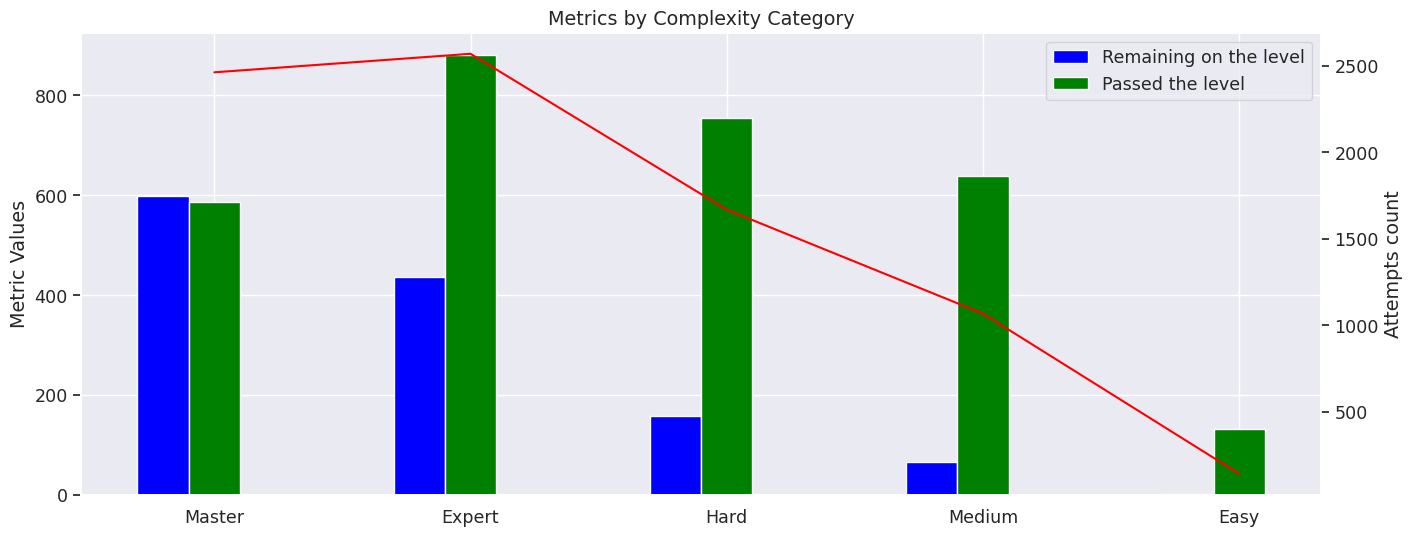

In [74]:
categories = metrics['complex_cat'].unique()
num_categories = len(categories)
x = np.arange(num_categories)
width = 0.2
fig, ax = plt.subplots(figsize = (16, 6))

bar1 = ax.bar(x - width, metrics.groupby('complex_cat',observed = True)['rem_level'].sum(), width, label='Remaining on the level', color = 'blue')
bar2 = ax.bar(x, metrics.groupby('complex_cat',observed = True)['pass_level'].sum(), width, label = 'Passed the level', color = 'green')

ax1 = ax.twinx()
ax1.plot(x, metrics.groupby('complex_cat',observed = True)['attempts_count'].sum(), color = 'red')

ax.set_ylabel('Metric Values')
ax.set_title('Metrics by Complexity Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

ax1.set_xticks(x)
ax1.set_ylabel('Attempts count')

plt.grid(False)
plt.show()

The dataset covers user activity for 1 December 2017. The volume of the dataset is 19999 records, with 7996 unique records. 

It is assumed that users are located in a region with UTC+5 (or UTC+6) time zone.
In addition, the possibility of playing the game while travelling to (from) work may indicate that users travel by public transport and are likely to be middle class.

Users' activity peaks in the morning and evening hours. Therefore, additional computing power should be considered to provide a comfortable gaming experience. At other times, resources can be reduced to optimise costs.

For each level of the game metrics are built, which allow you to effectively analyse the dataset. Based on the ‘Difficulty Level’ metric, a classification of game levels has been performed, resulting in a clear definition of 4 difficulty categories. For each category, statistical characteristics were calculated and charts were constructed to describe the changes in metrics depending on the categories. 

The dynamics of the metrics show an expected increase in the number of users who did not complete the higher difficulty levels. The percentage of players completing levels consistently decreases as we move to the next category, which logically reflects the increasing difficulty of the game.

The funnel demonstrates the movement of users through the game's difficulty categories, and shows how many users reached the levels of each category, as well as those who started to progress but failed to complete.

Let's take a closer look at the funnel for the ‘% of Passed Users’ metric. The percentage of users who passed the ‘Easy’ category is 99.24%. In the ‘Medium’ category, this drops to 90.64%, which is 8.6% less than ‘Easy’. Then, when we move to the ‘Hard’ category, the pass rate decreases again by 8.6%.

The most significant decrease is observed when moving from ‘Hard’ to ‘Expert’ - by 18.72%. 
This may indicate a sudden jump in difficulty that does not correspond to the gradual increase seen in previous stages. Such a sudden change can cause difficulty and demotivate players.

When moving from Expert to Master, this percentage decreases by a further 25.33%. Thus, the last stage shows a sharp drop in the percentage of users passing the level, indicating a significantly increased difficulty of the game in these stages.

In order to keep players motivated, it is important to provide a gradual increase in the difficulty of the levels. There is a sharp decline in the success rate of passing levels in the Expert and Master categories. This indicates the need for a possible revision of the difficulty of these categories. As a solution, additional tools such as bonuses or hints can be introduced to help players overcome the most difficult levels.

The difficulty level should be balanced to maintain player interest. For example, out of every 100 consecutive levels, approximately 10-15 may fall into the ‘Master’ category. If levels of the same difficulty category follow each other, it can reduce player engagement. Therefore, it is important to provide a smoother transition between levels to maintain interest and engagement throughout the game.

Monetisation offers can also be considered for the most challenging levels, where players can purchase help to complete difficult stages.
To effectively monetise the game, a limited number of free levels can be offered during the hours of highest user activity, after completing which further levels will be offered for purchase. In addition, on the most difficult levels, it is possible to offer paid progression to the next stage after, for example, 7 unsuccessful attempts.